In [42]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import librosa
import torch
import torchaudio

# import sys
# sys.path.append(r'C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID')
ROOT = "F:/DATAS/NEUCOUGHDATA_COUGHSINGLE/"

# Step 1 观察数据集

## 1.1 尝试根据时间截取片段

In [ ]:
slice_raw = pd.read_csv(ROOT+'neucough_metainfo_slice.txt', header=0, index_col=0)
slice_raw

In [43]:
def min2sec(t: str):
    parts = t.split(':')
    return int(parts[0]) * 60 + float(parts[1])

def read_audio(filepath: str, st=None, en=None):
    # print(y.shape, sr)
    # sr = 22050
    if (st is not None) and (en is not None):
        # st, en = int(st * sr), int(en * sr)
        # print("st, en:", st, en)
        y, sr = librosa.load(filepath, offset=st, duration=en - st)
        # print("y, sr:", len(y), sr)
    else:
        y, sr = librosa.load(filepath, )
        # print("y, sr:", y, sr)
    # print(y.shape)
    # mel = w2m(torch.from_numpy(y))
    return y, sr#  , mel

In [ ]:
for idx, item in enumerate(slice_raw.itertuples()):
    if idx >0:
        break
    name, st, en = item[0], item[1], item[2]
    print(name, st, en)
    audio_path = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(name)
    y = read_audio(audio_path, st=min2sec(st), en=min2sec(en))
    # plt.subplot(5, 1, idx+1)
    plt.figure(idx, figsize=(14, 5))
    plt.plot(y)

## 1.2 统计波形长度直方图

In [ ]:

sns.displot(slice_raw, x="slice", bins=10, height=4, aspect=3)

# Step 2 统计Mel谱图的形状，统一长度，长的Crop短的Padding

## 2.1 读取、按时间切分、转换Mel谱

In [ ]:

class Wave2Mel(object):
    def __init__(self, sr,
                 n_fft=1024,
                 n_mels=128,
                 win_length=1024,
                 hop_length=512,
                 power=2.0
                 ):
        self.mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr,
                                                                  win_length=win_length,
                                                                  hop_length=hop_length,
                                                                  n_fft=n_fft,
                                                                  n_mels=n_mels,
                                                                  power=power)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB(stype='power')

    def __call__(self, x):
        return self.amplitude_to_db(self.mel_transform(x))

In [ ]:
mel_length_list = []
sr_list = []
w2m = Wave2Mel(sr=22050)
fout = open("F:/DATAS/NEUCOUGHDATA_COUGHSINGLE/neucough_slicemel.txt", 'w')
fout.write("filename,duration,slice\n")
for idx, item in tqdm(enumerate(slice_raw.itertuples()), desc="Wav2Mel:"):
    name, st, en = item[0], item[1], item[2]
    audio_path = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(name)
    y, sr = read_audio(audio_path, st=min2sec(st), en=min2sec(en))
    sr_list.append(sr)

    mel = w2m(torch.from_numpy(y))
    dim, length = mel.data.numpy().shape
    mel_length_list.append([name, len(y), length])
    fout.write("{},{},{}\n".format(name, len(y), length))
fout.close()

In [ ]:
mel_raw = pd.read_csv(ROOT+'neucough_slicemel.txt', header=0, index_col=0)
mel_raw

## 2.2 统计Mel谱的长度统计直方图

In [31]:
mel_raw["slice"].mean()

12.838006230529595

C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


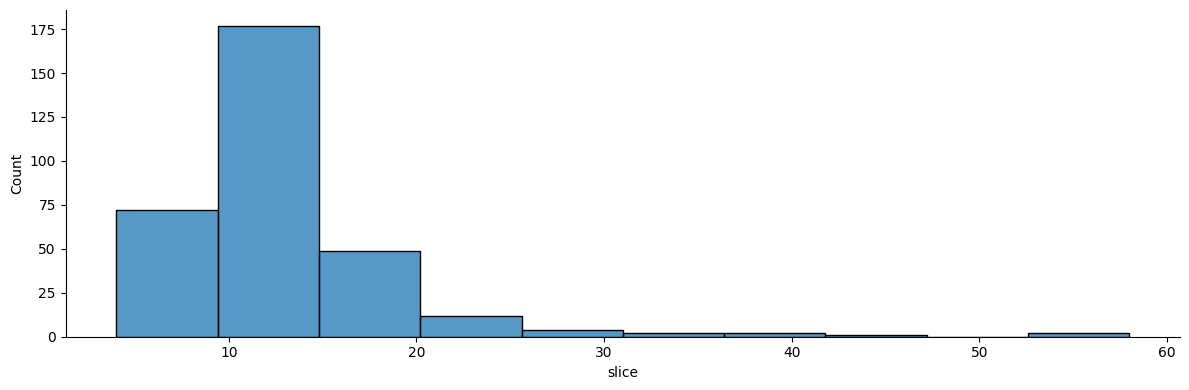

In [30]:
sns.displot(mel_raw, x="slice", bins=10, height=4, aspect=3)

## 2.3 统一长度，长的Crop短的Padding

### 当前存在一个问题：有的很长，可以随机截取多个，而不是只要一个

In [ ]:
fixed_length = 16
for idx, item in enumerate(slice_raw.itertuples()):
    name, st, en = item[0], item[1], item[2]
    st, en = min2sec(st), min2sec(en)
    audio_path = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(name)
    y, sr = read_audio(audio_path, st=min2sec(st), en=min2sec(en))
    mel = w2m(torch.from_numpy(y)).data.numpy()
    dim, length = mel.shape
    if length < 16:
        new_mel = np.zeros((128, 16))
        st = np.random.randint(0, (fixed_length-length+1)//2)
        new_mel[:, st:st+16] = mel
    elif length>16:
        st = np.random.randint(0, (length+1-fixed_length)//2)
        new_mel = mel[:, st:st+16]
    else:
        new_mel = mel
        # print("wav, mel length:", len(y), mel.shape)
    print(new_mel.shape)

# Step 3 从原始音频中随机截取一些负样本，作为训练，和Region Proposal

## 寻找切分多大的范围内，波形的mel谱才是16

In [ ]:
w2m = Wave2Mel(sr=22050)
for i in range(7679, 8193):
    x = np.random.rand((i))  # .astype(np.float64)
    # print(x.shape)
    mel = w2m(torch.from_numpy(x).to(torch.float32))
    print(len(x), mel.shape)

In [76]:
def min2sec(t: str):
    parts = t.split(':')
    return int(parts[0]) * 60 + float(parts[1])

def get_rand_start(sec: int, wav_length:int, mode="left", full_length: int=None, sr=22050):
    """ 除法/不要写成//，会导致算什么都是0 """
    if mode=="left":
        return np.random.randint(0, sec*sr-wav_length) / sr
    elif mode=="right":
        return np.random.randint(sec*sr, full_length-wav_length) / sr
    else:
        raise Exception("Unknown mode of get_rand_start(mode=\"???\").")

def read_audio(filepath: str, st=None, en=None, duration=None):
    # print(y.shape, sr)
    # sr = 22050
    if st is not None:
        if en is not None:
            # st, en = int(st * sr), int(en * sr)
            # print("st, en:", st, en)
            y, sr = librosa.load(filepath, offset=st, duration=en - st)
            # print("y, sr:", len(y), sr)
        elif duration is not None:
            y, sr = librosa.load(filepath, offset=st, duration=duration)
    else:
        y, sr = librosa.load(filepath)
            # print("y, sr:", y, sr)
    # print(y.shape)
    # mel = w2m(torch.from_numpy(y))
    return y, sr#  , mel

In [81]:

def labelling_by_IOU(st1:int, en1:int, st2:int, d2:int, mode="left"):
    print(st1,en1,st2,d2)
    if mode=="left":
        if st2+d2<st1:
            return 0  # other
        elif (st2+d2-st1)/(en1-st2) > 0.2:
            return 1
        else:
            return 0
    else:
        raise Exception("Unknown mode of labelling_by_IOU(mode=\"???\")")

In [84]:
lab2name = {0: "non-cough", 1:"cough"}
fixed_length = 16
for idx, item in enumerate(slice_raw.itertuples()):
    name, st, en = item[0], item[1], item[2]
    st, en = min2sec(st), min2sec(en)
    print("st, en:", st, en)
    audio_path = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(name)
    pos_sample, sr = read_audio(audio_path, st=st, en=en)
    pos_mel = w2m(torch.from_numpy(pos_sample).to(torch.float32))
    print("pos_sample:", pos_sample.shape, pos_mel.shape)
    print("label:", 1, lab2name[1])
    
    mel16_rand_wavlen = np.random.randint(7680, 8192)  # Mel length: 16
    print("wavlen:", mel16_rand_wavlen/sr)
    rand_start = get_rand_start(sec=st, wav_length=mel16_rand_wavlen, mode="left", full_length=None, sr=22050)
    print("rand_start:", rand_start)
    neg_sample, _ = read_audio(audio_path, st=rand_start, duration=mel16_rand_wavlen/sr)  # 除法/不要写成//，会导致算什么都是0
    neg_mel = w2m(torch.from_numpy(neg_sample).to(torch.float32))
    print("neg_sample:", neg_sample.shape, neg_mel.shape)
    gen_label = labelling_by_IOU(st1=st,en1=en,st2=rand_start,d2=mel16_rand_wavlen/sr)
    print("label:", gen_label, lab2name[gen_label])
    while gen_label==1:
        mel16_rand_wavlen = np.random.randint(7680, 8192)  # Mel length: 16
        print("wavlen:", mel16_rand_wavlen/sr)
        rand_start = get_rand_start(sec=st, wav_length=mel16_rand_wavlen, mode="left", full_length=None, sr=22050)
        print("rand_start:", rand_start)
        neg_sample, _ = read_audio(audio_path, st=rand_start, duration=mel16_rand_wavlen/sr)  # 除法/不要写成//，会导致算什么都是0
        print("neg_sample:", neg_sample.shape)
        gen_label = labelling_by_IOU(st1=st,en1=en,st2=rand_start,d2=mel16_rand_wavlen/sr)
        print("label:", gen_label, lab2name[gen_label])
    print()
    if idx>2:
        print("idx:", idx, mel16_rand_wavlen)
        break

st, en: 184.34 184.64
pos_sample: (6615,) torch.Size([128, 13])
label: 1 cough
wavlen: 0.3672108843537415
rand_start: 36.81414965986394
neg_sample: (8097,) torch.Size([128, 16])
184.34 184.64 36.81414965986394 0.3672108843537415
label: 0 non-cough

st, en: 184.62 184.88
pos_sample: (5733,) torch.Size([128, 12])
label: 1 cough
wavlen: 0.3658956916099773
rand_start: 85.08036281179139
neg_sample: (8068,) torch.Size([128, 16])
184.62 184.88 85.08036281179139 0.3658956916099773
label: 0 non-cough

st, en: 184.86 185.12
pos_sample: (5733,) torch.Size([128, 12])
label: 1 cough
wavlen: 0.3495238095238095
rand_start: 107.61786848072562
neg_sample: (7707,) torch.Size([128, 16])
184.86 185.12 107.61786848072562 0.3495238095238095
label: 0 non-cough

st, en: 181.5 181.93
pos_sample: (9482,) torch.Size([128, 19])
label: 1 cough
wavlen: 0.35306122448979593
rand_start: 46.34988662131519
neg_sample: (7785,) torch.Size([128, 16])
181.5 181.93 46.34988662131519 0.35306122448979593
label: 0 non-cough

id

# End